## ASHRAE : Lgbm Simple FE WITH PYTHON and MLOPS with MLFoundry
[Crislânio Macêdo](https://medium.com/sapere-aude-tech) -  June, 23th, 2021

EDA ⚡🔌ASHRAE : Gentle Introduction: [⚡🔌Start Here: A Gentle Introduction](https://www.kaggle.com/caesarlupum/ashrae-start-here-a-gentle-introduction)

----------
----------

![image](https://www.shell.com/energy-and-innovation/the-energy-future/scenarios/shell-scenario-sky/_jcr_content/pageCarouselImage.img.960.jpeg/1521983923121/future-of-energy-homepage-r.jpeg?imwidth=960)

<html>
<body>

<p><font size="5" color="Blue">⚡🔌ASHRAE - LigthGBM simple FE </p>

</body>
</html>



### <a href='#0'> In this kernel I want to show a Exhaustive Analysis of ASHRAE - Great Energy Predictor III, with:</a>


- <a href='#1'>1. Glimpse of Data</a>
- <a href='#2'>2. Reducing Memory Size</a>
- <a href='#3'>3. ASHRAE - Data minification</a>
- <a href='#4'>4. Encoding Variables</a>
- <a href='#5'>5. Feature Engineering</a>
- <a href='#6'>6. Exploratory Data Analysis</a>
    - <a href='#6-1'>6.1 Examine the Distribution of the Target Column</a>
    - <a href='#6-2'>6.2 Examine Missing Values</a>
- <a href='#7'>7. Handling missing values</a>
- <a href='#8'>8. Outlier Analysis</a>
    - <a href='#8-1'>8.1. Outlier Distribution</a>
- <a href='#9'>9. Plotings</a>
- <a href='#10'>10. Baseline</a>
- <a href='#11'>11. Blend</a>
- <a href='#12'>12. Submission</a>
- <a href='#13'>13. ASHRAE Energy prediction - summary</a>



A period of baseline energy consumption is used to create a machine learning prediction model to
evaluate how much energy a building would use in a status quo baseline mode. An energy conservation measure (ECM) is installed and the difference between the baseline is the avoided energy consumption or demand. This process is crucial for the implementation of energy savings implementations as it gives building owners, designers and contractors a means of evaluating the success of such measures.

For further details, I recommend reading [this paper by Clayton Miller ](https://www.mdpi.com/2504-4990/1/3/56)

![](https://www.mdpi.com/make/make-01-00056/article_deploy/html/images/make-01-00056-g001-550.jpg)


<html>
<body>

<p><font size="4" color="Gray">If you find this kernel useful or interesting, please don't forget to upvote the kernel =)

</body>
</html>



# In This kernel [🔌ASHRAE -Start Here: A GENTLE Introduction](https://www.kaggle.com/caesarlupum/ashrae-start-here-a-gentle-introduction), We saw a gentle introduction of the data. 


<html>
<body>

<p><font size="4" color="Blue"> ASHRAE 90.1-2016, Energy Standard for Buildings - Review of Changes</font></p>
</body>
</html>


In [ ]:
# Suppress warnings 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
from IPython.display import HTML


HTML('<iframe width="1106" height="622" src="https://www.youtube.com/embed/NZyQu1u3N9Y" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

## Imports

> We are using a typical data science stack: `numpy`, `pandas`, `sklearn`, `matplotlib`. 

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')
import gc


# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import matplotlib.patches as patches
from scipy import stats
from scipy.stats import skew

from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
pd.set_option('max_columns', 100)

py.init_notebook_mode(connected=True)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import os,random, math, psutil, pickle
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold
from tqdm import tqdm


## Read in Data 

First, we can list all the available data files. There are a total of 6 files: 1 main file for training (with target) 1 main file for testing (without the target), 1 example submission file, and 4 other files containing additional information about energy types based on historic usage rates and observed weather. . 

In [ ]:
%%time
root = '../input/ashrae-energy-prediction/'
train_df = pd.read_csv(root + 'train.csv')
train_df["timestamp"] = pd.to_datetime(train_df["timestamp"], format='%Y-%m-%d %H:%M:%S')

weather_train_df = pd.read_csv(root + 'weather_train.csv')
test_df = pd.read_csv(root + 'test.csv')
weather_test_df = pd.read_csv(root + 'weather_test.csv')
building_meta_df = pd.read_csv(root + 'building_metadata.csv')
sample_submission = pd.read_csv(root + 'sample_submission.csv')


# <a id='1'>1. Glimpse of Data</a>
<a href='#0'>Top</a>

In [ ]:
print('Size of train_df data', train_df.shape)
print('Size of weather_train_df data', weather_train_df.shape)
print('Size of weather_test_df data', weather_test_df.shape)
print('Size of building_meta_df data', building_meta_df.shape)

# <a id='2'>2. Reducing Memory Size</a>
<a href='#1'>Top</a>
> It is necessary that after using this code, carefully check the output results for each column.

In [ ]:
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
## REducing memory
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

weather_train_df = reduce_mem_usage(weather_train_df)
weather_test_df = reduce_mem_usage(weather_test_df)
building_meta_df = reduce_mem_usage(building_meta_df)

# 🔓MEMORY USAGE AFTER COMPLETION:

Mem. usage decreased to : 289.19 Mb (53.1% reduction)

Mem. usage decreased to : 6.08 Mb (68.1% reduction)

Mem. usage decreased to : 0.03 Mb (60.3% reduction)

> ## Building DF merge through concat 




> - Convert timestamp 
> - Convert Strings to category


In [ ]:
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])
test_df['timestamp'] = pd.to_datetime(test_df['timestamp'])

weather_train_df['timestamp'] = pd.to_datetime(weather_train_df['timestamp'])
weather_test_df['timestamp'] = pd.to_datetime(weather_test_df['timestamp'])

building_meta_df['primary_use'] = building_meta_df['primary_use'].astype('category')

In [ ]:
temp_df = train_df[['building_id']]
temp_df = temp_df.merge(building_meta_df, on=['building_id'], how='left')
del temp_df['building_id']
train_df = pd.concat([train_df, temp_df], axis=1)

temp_df = test_df[['building_id']]
temp_df = temp_df.merge(building_meta_df, on=['building_id'], how='left')

del temp_df['building_id']
test_df = pd.concat([test_df, temp_df], axis=1)
del temp_df, building_meta_df


> ## Weather DF merge over concat


In [ ]:
temp_df = train_df[['site_id','timestamp']]
temp_df = temp_df.merge(weather_train_df, on=['site_id','timestamp'], how='left')

del temp_df['site_id'], temp_df['timestamp']
train_df = pd.concat([train_df, temp_df], axis=1)

temp_df = test_df[['site_id','timestamp']]
temp_df = temp_df.merge(weather_test_df, on=['site_id','timestamp'], how='left')

del temp_df['site_id'], temp_df['timestamp']
test_df = pd.concat([test_df, temp_df], axis=1)

del temp_df, weather_train_df, weather_test_df


# <a id='3'>3. ASHRAE - Data minification</a>
<a href='#1'>Top</a>


> Use can use train_df.pkl, test_df.pkl for FE, FS for your baseline_predict


In [ ]:
train_df.to_pickle('train_df.pkl')
test_df.to_pickle('test_df.pkl')
   
del train_df, test_df
gc.collect()

In [ ]:
train_df = pd.read_pickle('train_df.pkl')
test_df = pd.read_pickle('test_df.pkl')

# <a id='4'>4. Encoding Variables</a>
<a href='#1'>Top</a>

Before we go any further, we need to deal with pesky categorical variables. A machine learning model unfortunately cannot deal with categorical variables (except for some models such as [LightGBM](http://https://lightgbm.readthedocs.io/en/latest/Features.html). Therefore, we have to find a way to encode (represent) these variables as numbers before handing them off to the model. There are two main ways to carry out this process:

You can see [this](https://www.kaggle.com/alexisbcook/categorical-variables):
- ## Label Encoding:

Label encoding assigns each unique value to a different integer.
![](https://raw.githubusercontent.com/WillKoehrsen/Machine-Learning-Projects/master/label_encoding.png)

This approach assumes an ordering of the categories: "Never" (0) < "Rarely" (1) < "Most days" (2) < "Every day" (3).

This assumption makes sense in this example, because there is an indisputable ranking to the categories. Not all categorical variables have a clear ordering in the values, but we refer to those that do as ordinal variables. For tree-based models (like decision trees and random forests), you can expect label encoding to work well with ordinal variables.


### Points of the compass
Compass points

The names of the compass point directions follow these rules:
> #### 16-wind compass rose
   - The eight half-winds are the direction points obtained by bisecting the angles between the principal winds. The half-winds are north-northeast (NNE), east-northeast (ENE), east-southeast (ESE), south-southeast (SSE), south-southwest (SSW), west-southwest (WSW), west-northwest (WNW) and north-northwest (NNW). The name of each half-wind is constructed by combining the names of the principal winds to either side, with the cardinal wind coming first and the intercardinal wind second.
   - The eight principal winds and the eight half-winds together form the 16-wind compass rose, with each compass point at a ​22 1⁄2° angle from its two neighbours.

In [ ]:
# Convert wind direction into categorical feature. We can split 360 degrees into 16-wind compass rose. 
# See this: https://en.wikipedia.org/wiki/Points_of_the_compass#16-wind_compass_rose
def degToCompass(num):
    val=int((num/22.5))
    arr=[i for i in range(0,16)]
    return arr[(val % 16)]

In [ ]:
le = LabelEncoder()

train_df['primary_use'] = le.fit_transform(train_df['primary_use']).astype(np.int8)

test_df['primary_use'] = le.fit_transform(test_df['primary_use']).astype(np.int8)

In [ ]:
train_df['age'] = train_df['year_built'].max() - train_df['year_built'] + 1
test_df['age'] = test_df['year_built'].max() - test_df['year_built'] + 1

See this, [simple FE](https://www.kaggle.com/isaienkov/lightgbm-fe-1-19): 

# Feature Selection
     
#### Find the optimal feature subset using an evaluation measure. The choice of evaluation metric distinguish the three main strategies of feature selection algorithms: the wrapper strategy, the filter strategy, and the embedded strategy.

    Filter methods:
        information gain
        chi-square test
        correlation coefficient
        variance threshold
    Wrapper methods:
        recursive feature elimination
        sequential feature selection algorithms
    Embedded methods:
        L1 (LASSO) regularization
        decision tree
        
In our case, we remove some useless, redundant variables. 

In [ ]:
def average_imputation(df, column_name):
    imputation = df.groupby(['timestamp'])[column_name].mean()
    
    df.loc[df[column_name].isnull(), column_name] = df[df[column_name].isnull()][[column_name]].apply(lambda x: imputation[df['timestamp'][x.index]].values)
    del imputation
    return df

In [ ]:
train_df = average_imputation(train_df, 'wind_speed')
train_df = average_imputation(train_df, 'wind_direction')

beaufort = [(0, 0, 0.3), (1, 0.3, 1.6), (2, 1.6, 3.4), (3, 3.4, 5.5), (4, 5.5, 8), (5, 8, 10.8), (6, 10.8, 13.9), 
          (7, 13.9, 17.2), (8, 17.2, 20.8), (9, 20.8, 24.5), (10, 24.5, 28.5), (11, 28.5, 33), (12, 33, 200)]

for item in beaufort:
    train_df.loc[(train_df['wind_speed']>=item[1]) & (train_df['wind_speed']<item[2]), 'beaufort_scale'] = item[0]

train_df['wind_direction'] = train_df['wind_direction'].apply(degToCompass)
train_df['beaufort_scale'] = train_df['beaufort_scale'].astype(np.uint8)
train_df["wind_direction"] = train_df['wind_direction'].astype(np.uint8)
train_df["meter"] = train_df['meter'].astype(np.uint8)
train_df["site_id"] = train_df['site_id'].astype(np.uint8)
    
    
test_df = average_imputation(test_df, 'wind_speed')
test_df = average_imputation(test_df, 'wind_direction')

for item in beaufort:
    test_df.loc[(test_df['wind_speed']>=item[1]) & (test_df['wind_speed']<item[2]), 'beaufort_scale'] = item[0]

test_df['wind_direction'] = test_df['wind_direction'].apply(degToCompass)
test_df['wind_direction'] = test_df['wind_direction'].apply(degToCompass)
test_df['beaufort_scale'] = test_df['beaufort_scale'].astype(np.uint8)
test_df["wind_direction"] = test_df['wind_direction'].astype(np.uint8)
test_df["meter"] = test_df['meter'].astype(np.uint8)
test_df["site_id"] = test_df['site_id'].astype(np.uint8)

# <a id='5'>5. Feature Engineering</a>
<a href='#1'>Top</a>

## Datetime Features

In [ ]:
train_df['month_datetime'] = train_df['timestamp'].dt.month.astype(np.int8)
train_df['weekofyear_datetime'] = train_df['timestamp'].dt.weekofyear.astype(np.int8)
train_df['dayofyear_datetime'] = train_df['timestamp'].dt.dayofyear.astype(np.int16)
    
train_df['hour_datetime'] = train_df['timestamp'].dt.hour.astype(np.int8)  
train_df['day_week'] = train_df['timestamp'].dt.dayofweek.astype(np.int8)
train_df['day_month_datetime'] = train_df['timestamp'].dt.day.astype(np.int8)
train_df['week_month_datetime'] = train_df['timestamp'].dt.day/7
train_df['week_month_datetime'] = train_df['week_month_datetime'].apply(lambda x: math.ceil(x)).astype(np.int8)
    
    
test_df['month_datetime'] = test_df['timestamp'].dt.month.astype(np.int8)
test_df['weekofyear_datetime'] = test_df['timestamp'].dt.weekofyear.astype(np.int8)
test_df['dayofyear_datetime'] = test_df['timestamp'].dt.dayofyear.astype(np.int16)
    
test_df['hour_datetime'] = test_df['timestamp'].dt.hour.astype(np.int8)
test_df['day_week'] = test_df['timestamp'].dt.dayofweek.astype(np.int8)
test_df['day_month_datetime'] = test_df['timestamp'].dt.day.astype(np.int8)
test_df['week_month_datetime'] = test_df['timestamp'].dt.day/7
test_df['week_month_datetime'] = test_df['week_month_datetime'].apply(lambda x: math.ceil(x)).astype(np.int8)
    

> #### train_df data

In [ ]:
train_df.head()

train_df.columns.values

In [ ]:
train_df.columns.values

# <a id='6'>6. Exploratory Data Analysis</a>
<a href='#1'>Top</a>

Exploratory Data Analysis (EDA) is an open-ended process where we calculate statistics and make figures to find trends, anomalies, patterns, or relationships within the data. 

# <a id='6-1'>6.1 Examine the Distribution of the Target Column</a>
<a href='#1'>Top</a>


The target is meter_reading - Energy consumption in kWh (or equivalent). Note that this is real data with measurement error, which we expect will impose a baseline level of modeling error.

In [ ]:
plt.figure(figsize = (15,5))
train_df['meter_reading'].plot()

In [ ]:
train_df['meter_reading'].plot(kind='hist',
                            bins=25,
                            figsize=(15, 5),
                           title='Distribution of Target Variable (meter_reading)')
plt.show()

> ### Target's log-log histogram:

In [ ]:
ax = np.log1p(train_df['meter_reading']).hist()
ax.set_yscale('log')
train_df.meter_reading.describe()

# <a id='6-2'>6.2 Examine Missing Values</a>
<a href='#1'>Top</a>


Next we can look at the number and percentage of missing values in each column. 

In [ ]:
# checking missing data
total = train_df.isnull().sum().sort_values(ascending = False)
percent = (train_df.isnull().sum()/train_df.isnull().count()*100).sort_values(ascending = False)
missing__train_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing__train_data.head(10)

## Column Types

Let's look at the number of columns of each data type. `int64` and `float64` are numeric variables ([which can be either discrete or continuous](https://stats.stackexchange.com/questions/206/what-is-the-difference-between-discrete-data-and-continuous-data)). `object` columns contain strings and are  [categorical features.](http://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/supporting-topics/basics/what-are-categorical-discrete-and-continuous-variables/) . 

In [ ]:
# Number of each type of column
train_df.dtypes.value_counts()

In [ ]:
# Number of unique classes in each object column
train_df.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

# <a id='7'>7. Handling missing values</a>
<a href='#1'>Top</a>

Package called missingno (https://github.com/ResidentMario/missingno)

     !pip install quilt

In [ ]:
import missingno as msno

**Nullity Matrix**

The msno.matrix nullity matrix is a data-dense display which lets you quickly visually analyse data completion. 


In [ ]:
msno.matrix(train_df.head(20000))

**Heatmap**

The missingno correlation heatmap measures nullity correlation: how strongly the presence or absence of one variable affects the presence of another:

In [ ]:
a = msno.heatmap(train_df, sort='ascending')

Manually dealing with missing values will often improve model performance. 

Our approach we input fillNaN = -999 just for the 4 features with most missing values.


In [ ]:
train_df['floor_count'] = train_df['floor_count'].fillna(-999).astype(np.int16)
test_df['floor_count'] = test_df['floor_count'].fillna(-999).astype(np.int16)

train_df['year_built'] = train_df['year_built'].fillna(-999).astype(np.int16)
test_df['year_built'] = test_df['year_built'].fillna(-999).astype(np.int16)

train_df['age'] = train_df['age'].fillna(-999).astype(np.int16)
test_df['age'] = test_df['age'].fillna(-999).astype(np.int16)

train_df['cloud_coverage'] = train_df['cloud_coverage'].fillna(-999).astype(np.int16)
test_df['cloud_coverage'] = test_df['cloud_coverage'].fillna(-999).astype(np.int16) 

#### Still in progress

# <a id='8'>8.  Outlier Analysis</a>
<a href='#1'>Top</a>

See this: [ASHRAE: EDA and Visualization (wip)](https://www.kaggle.com/chmaxx/ashrae-eda-and-visualization-wip) (upvote this !) Not only useful but also valuable

In [ ]:
energy_types_dict = {0: "electricity", 1: "chilledwater", 2: "steam", 3: "hotwater"}
energy_types      = ['electricity', 'chilledwater', 'steam', 'hotwater']

plt.figure(figsize=(16,7))
tmp_df = train_df.meter.value_counts()
tmp_df.index = energy_types
tmp_df.sort_values().plot(kind="barh")
plt.title(f"Most readings measure electricity")
plt.xlabel("Count of measurements")
plt.ylabel(f"Meter type")
plt.tight_layout()
plt.show()

plt.figure(figsize=(16,5))
tmp_df = train_df.groupby("meter").meter_reading.sum()
tmp_df.index = energy_types
tmp_df.sort_values().plot(kind="barh")
plt.title(f"Generating steam consumes most energy")
plt.xlabel("Sum of consumed energy")
plt.ylabel(f"Type of energy")
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(16,5))
sns.distplot(train_df.meter_reading, hist=False)
plt.title(f"Target variable meter_reading is highly skewed")
plt.ylabel("Count of readings")
plt.xlabel(f"Measured consumption")
plt.xlim(0, train_df.meter_reading.max() + 100_000)
plt.tight_layout()
plt.show()

plt.figure(figsize=(16,5))
sns.distplot(np.log1p(train_df.meter_reading))
plt.title(f"After log transform, meter readings look more workable but still skewed")
plt.ylabel("Count of readings")
plt.xlabel(f"Measured consumption")
plt.xlim(0, 12)
plt.tight_layout()
plt.show()

plt.figure(figsize=(16,5))
for idx in range(0,4):
    sns.distplot(np.log1p(train_df[train_df.meter==idx].meter_reading), hist=False, label=energy_types[idx])
plt.title(f"After log transform, distributions of energy types look comparably skewed")
plt.ylabel("Count of readings")
plt.xlabel(f"Measured consumption")
plt.legend()
plt.xlim(0, 12)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(16,7))
_ = stats.probplot(train_df['meter_reading'], plot=plt)
plt.title("Probability plot for meter_reading shows extreme skewness")
plt.show()

> ### Meter readings for first 10 buildings [ 1,2,3,4,5,6,7,8,9,10]

In [ ]:
for bldg_id in [0, 1, 2, 2, 4,5, 6,7,8,9,10]:
    plt.figure(figsize=(16,5))
    tmp_df = train_df[train_df.building_id == bldg_id].copy()
    tmp_df.set_index("timestamp", inplace=True)
    tmp_df.resample("D").meter_reading.sum().plot()
    plt.title(f"Meter readings for building #{bldg_id} ")
    plt.xlabel("Sum of readings")
    plt.tight_layout()
    plt.show()

In [ ]:
temp_df = train_df.groupby("primary_use").meter_reading.sum().sort_values()

plt.figure(figsize=(16,9))
temp_df.plot(kind="barh")
plt.title(f"Education buildings consume by far most of energy")
plt.xlabel("Sum of readings")
plt.ylabel(f"Primary use")
plt.tight_layout()
plt.show()

plt.figure(figsize=(16,9))
temp_df[:-1].plot(kind="barh")
plt.title(f"Among other types, office buildings consume most energy")
plt.xlabel("Sum of readings")
plt.ylabel(f"Primary use w/o «Education»")
plt.tight_layout()
plt.show()

# <a id='8-1'>8.1  Outlier Distribution</a>
<a href='#1'>Top</a>


In [ ]:
y_mean_time = train_df.groupby('timestamp').meter_reading.mean()
y_mean_time.plot(figsize=(20, 8))

In [ ]:
y_mean_time.rolling(window=10).std().plot(figsize=(20, 8))
plt.axhline(y=0.009, color='red')
plt.axvspan(0, 905, color='green', alpha=0.1)
plt.axvspan(906, 1505, color='red', alpha=0.1)


[ASHAE Outliers: by juanmah](https://www.kaggle.com/juanmah/ashrae-outliers) (upvoted this)

In [ ]:
daily_train = train_df
daily_train['date'] = daily_train['timestamp'].dt.date
daily_train = daily_train.groupby(['date', 'building_id', 'meter']).sum()
daily_train

daily_train_agg = daily_train.groupby(['date', 'meter']).agg(['sum', 'mean', 'idxmax', 'max'])
daily_train_agg = daily_train_agg.reset_index()
level_0 = daily_train_agg.columns.droplevel(0)
level_1 = daily_train_agg.columns.droplevel(1)
level_0 = ['' if x == '' else '-' + x for x in level_0]
daily_train_agg.columns = level_1 + level_0
daily_train_agg.rename_axis(None, axis=1)
daily_train_agg.head()

## ⚡🔌Aggregate the data for buildings

In [ ]:
daily_train_agg = daily_train.groupby(['date', 'meter']).agg(['sum', 'mean', 'idxmax', 'max'])
daily_train_agg = daily_train_agg.reset_index()
level_0 = daily_train_agg.columns.droplevel(0)
level_1 = daily_train_agg.columns.droplevel(1)
level_0 = ['' if x == '' else '-' + x for x in level_0]
daily_train_agg.columns = level_1 + level_0
daily_train_agg.rename_axis(None, axis=1)
daily_train_agg.head()

In [ ]:
fig_total = px.line(daily_train_agg, x='date', y='meter_reading-sum', color='meter', render_mode='svg')
fig_total.update_layout(title='Total kWh per energy aspect')
fig_total.show()

The sum for each energy aspect, shows some aberrant values.

- meter=0    **Eletricity**

- meter=1    **Chilledwater**

- meter=2    **Steam**

- meter=3    **Hotwater**

In [ ]:
fig_maximum = px.line(daily_train_agg, x='date', y='meter_reading-max', color='meter', render_mode='svg')
fig_maximum.update_layout(title='Maximum kWh value per energy aspect')
fig_maximum.show()

# Some 'Anomalies' - max meter reading

In [ ]:
daily_train_agg['building_id_max'] = [x[1] for x in daily_train_agg['meter_reading-idxmax']]
daily_train_agg.head()

# <a id='10'>10. Baseline</a>
<a href='#1'>Top</a>

> - Drop collumns

In [ ]:
del train_df["timestamp"], test_df["timestamp"]

In [ ]:
categoricals = ["site_id", "building_id", "primary_use",  "meter",  "wind_direction"] #"hour", "weekday",

In [ ]:
drop_cols = ["sea_level_pressure", "wind_speed"]

numericals = ["square_feet", "year_built", "air_temperature", "cloud_coverage",
              "dew_temperature", 'precip_depth_1_hr', 'floor_count', 'beaufort_scale']

feat_cols = categoricals + numericals

In [ ]:
target = np.log1p(train_df["meter_reading"])

del train_df["meter_reading"] 

train_df = train_df.drop(drop_cols, axis = 1)

> Modeling simple LGBM

# What is K-Fold Cross Validation?


**K-Fold CV[](https://medium.com/datadriveninvestor/k-fold-cross-validation-6b8518070833)** is where a given data set is split into a K number of sections/folds where each fold is used as a testing set at some point. Lets take the scenario of 5-Fold cross validation(K=5). Here, the data set is split into 5 folds. In the first iteration, the first fold is used to test the model and the rest are used to train the model. In the second iteration, 2nd fold is used as the testing set while the rest serve as the training set. This process is repeated until each fold of the 5 folds have been used as the testing set.
![5-Fold Cross Validation](https://miro.medium.com/max/1509/1*IjKy-Zc9zVOHFzMw2GXaQw.png)

# Getting started with MLFoundry

What is MLFoundry?
MLFoundry is world's first integrated experimented tracking & inference monitoring solution. Our client-side library allows you to log your experiments, models, metrics, data, features & predictions. Our interactive & intuitive dashboards allows you to track your Machine Learning models during develoment (experiment tracking) and post deployment (inference monitoring). Experiment Tracking: Helps you to create reproducible Machine Learning experiments and collaborate with your team by tracking your code, artefacts, hyperparameters & metrics all in one place. This is built on top of MLFlow where we solve for a lot of issues like Role Based Access Control, first class support for non-scalar metrics & full data observability. This is already live- get started here. Inference Monitoring: Helps you to track your model and feature health during inference. Supports model input/ output monitoring, feature drift and distribution tracking. Our dashboards presents a unique hierarchical view of the system to perform root cause analysis where you can see metrics at the service level and debug it down to a row level.

link: https://docs.truefoundry.com/mlfoundry/

### Install dependencies

In [ ]:
! pip install --quiet "numpy>=1.0.0,<2.0.0" "pandas>=1.0.0,<2.0.0" "matplotlib>=3.5.2,<3.6.0" scikit-learn shap==0.40.0
! pip install -U mlfoundry

# Initialize MLFoundry Client

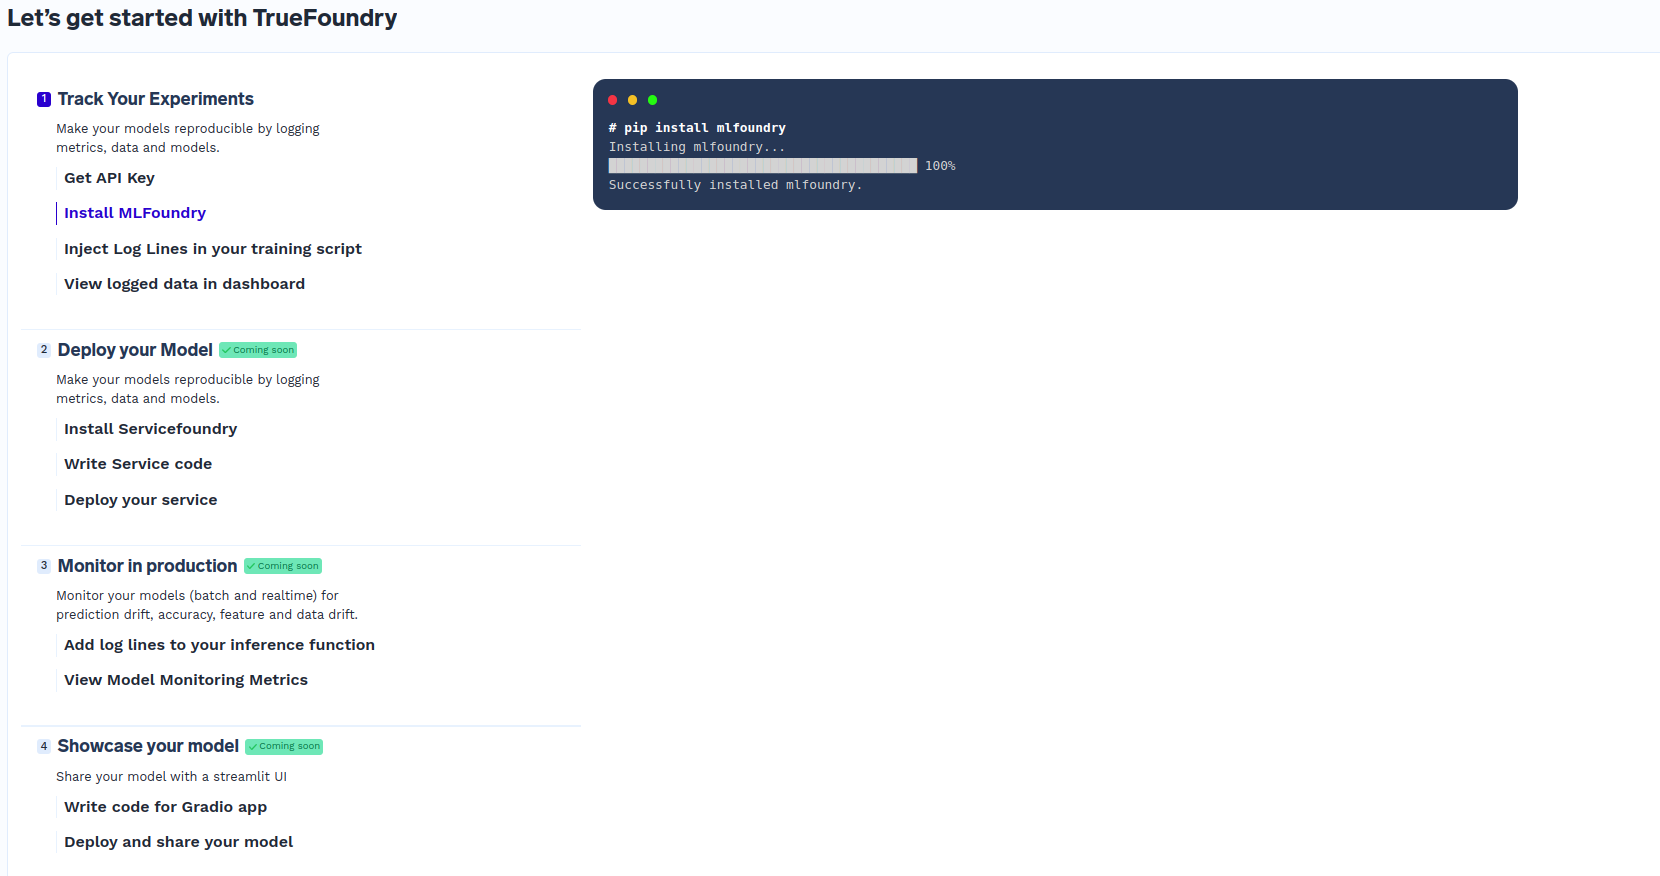

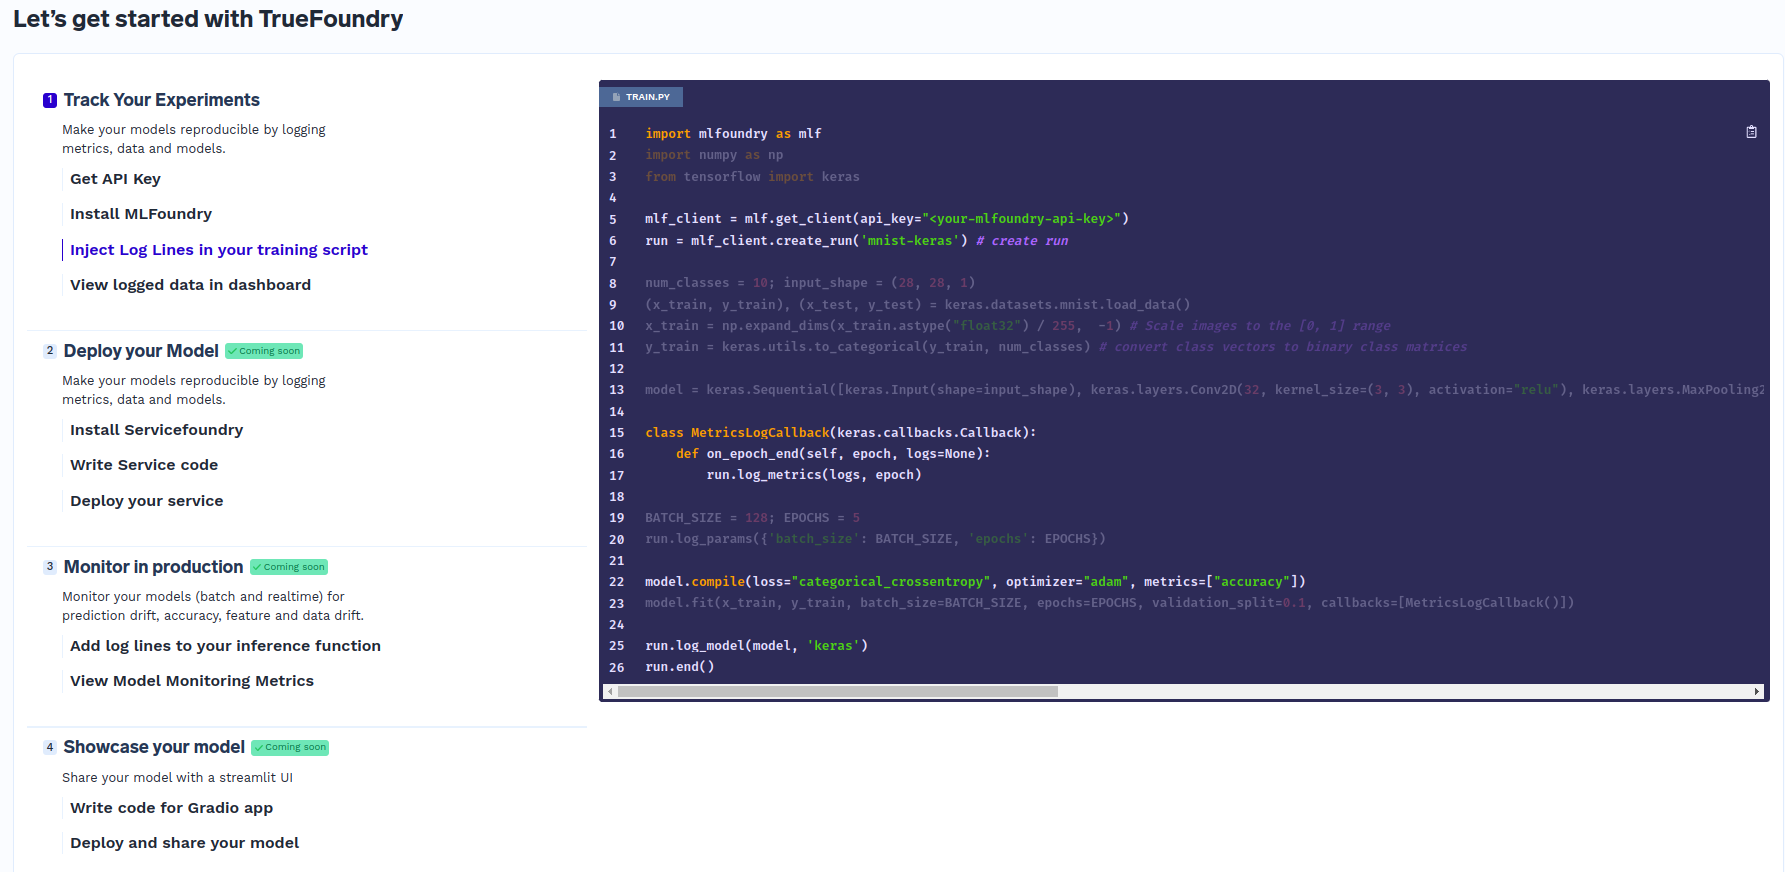

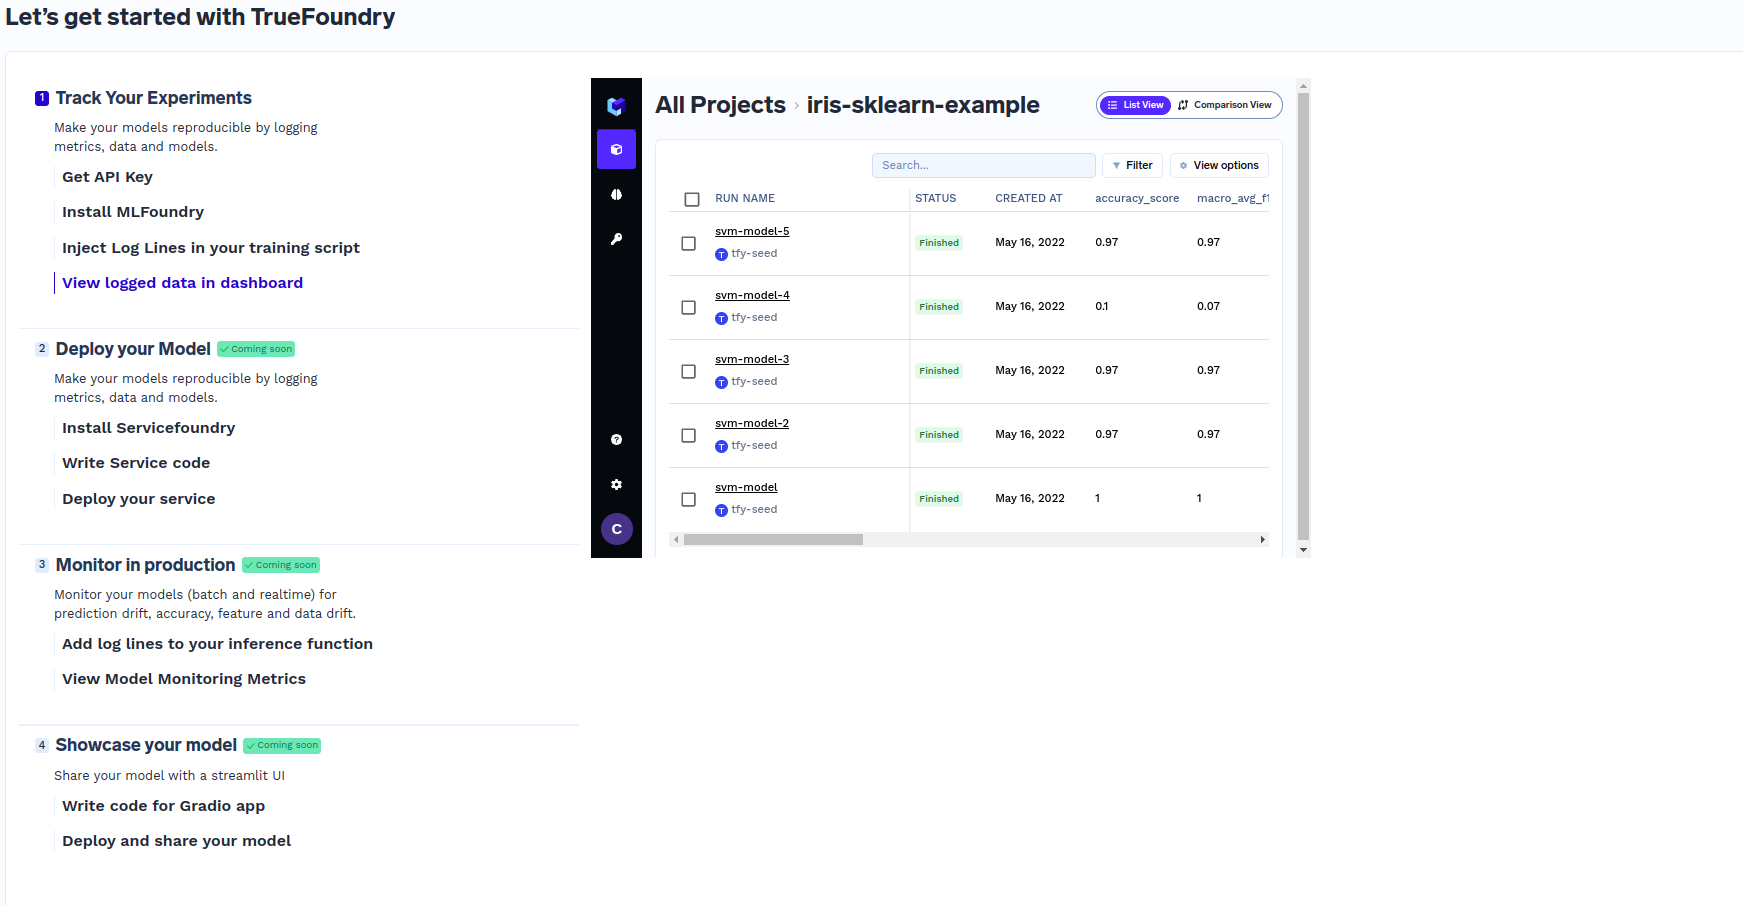


In [ ]:
import getpass
import urllib.parse
import mlfoundry as mlf

We will login using mlf.get_client and use pass our API Key on api_key.

In [ ]:
MLF_API_KEY = getpass.getpass("Paste your API key and hit enter:")

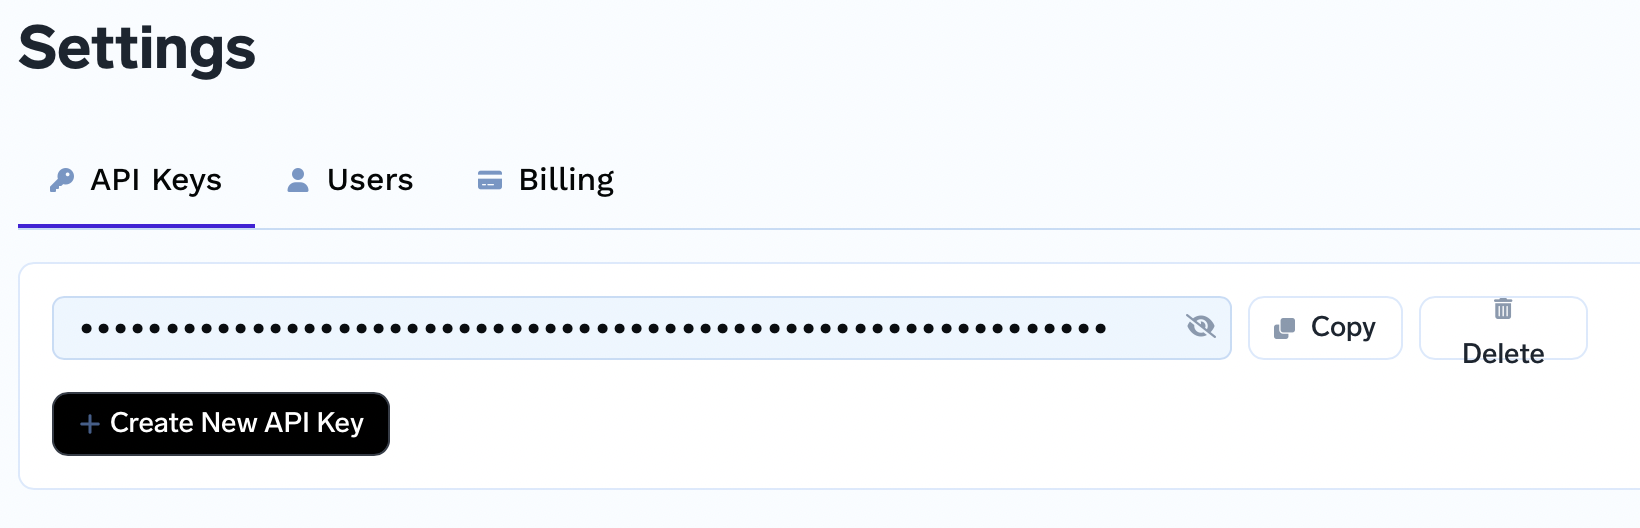

> https://app.truefoundry.com/signup

In [ ]:
client = mlf.get_client(api_key=MLF_API_KEY)

# Start MLFoundry Run


In [ ]:
run = client.create_run(project_name='ASHRAE-project', run_name="catbooskregressor")
print('RUN 1 ID:', run.run_id)
print(f'You can track your runs live at https://app.truefoundry.com/mlfoundry')

In [ ]:
%%time
from catboost import CatBoostRegressor
train_oof = np.zeros((train_df.shape[0],))
folds = 5
seed = 101
shuffle = True
skf = KFold(n_splits=folds, shuffle=shuffle, random_state=seed)
for fold, (train_idx, valid_idx) in enumerate(skf.split(train_df[feat_cols], train_df['building_id'])):
    train, valid = train_df.iloc[train_idx], train_df.iloc[valid_idx]
    y_train = train['building_id']
    y_valid = valid['building_id']
    X_train = train[feat_cols]
    X_valid = valid[feat_cols]
    model = CatBoostRegressor(iterations=10, loss_function='RMSE', random_state=42)    
    model = model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], use_best_model=False, verbose=0)
    
    temp_oof = model.predict(X_valid)
    train_oof[valid_idx] = temp_oof    
    rmse = (np.sqrt(mean_squared_error(y_valid, temp_oof)))
    print(f'Fold {fold} RMSE: ',rmse)
    
    results = model.get_evals_result()
    epochs = len(results['validation']['RMSE'])
    for global_step in range(epochs):
        run.log_metrics(metric_dict={f'RMSE_fold_{fold}':results['validation']['RMSE'][global_step]}, step=global_step) #TrueFoundry
    run.log_dataset(dataset_name="fold_"+str(fold), features=X_valid, actuals=y_valid, predictions=temp_oof) #TrueFoundry
rmse = (np.sqrt(mean_squared_error(train_df['building_id'], train_oof)))
print(f'OOF RMSE: ', rmse)

run.log_params(model.get_params()) #TrueFoundry
run.log_metrics(metric_dict={'RMSE_OOF':rmse}) #TrueFoundry
run.log_dataset(features=train_df[feat_cols], dataset_name="full", actuals=train_df['building_id'], predictions=train_oof) #TrueFoundry

run.end() #TrueFoundry

# Projects
We can check all of our projects in ML Foundry section. In this case we are looking for our ASHRAE-project catbooskregressor
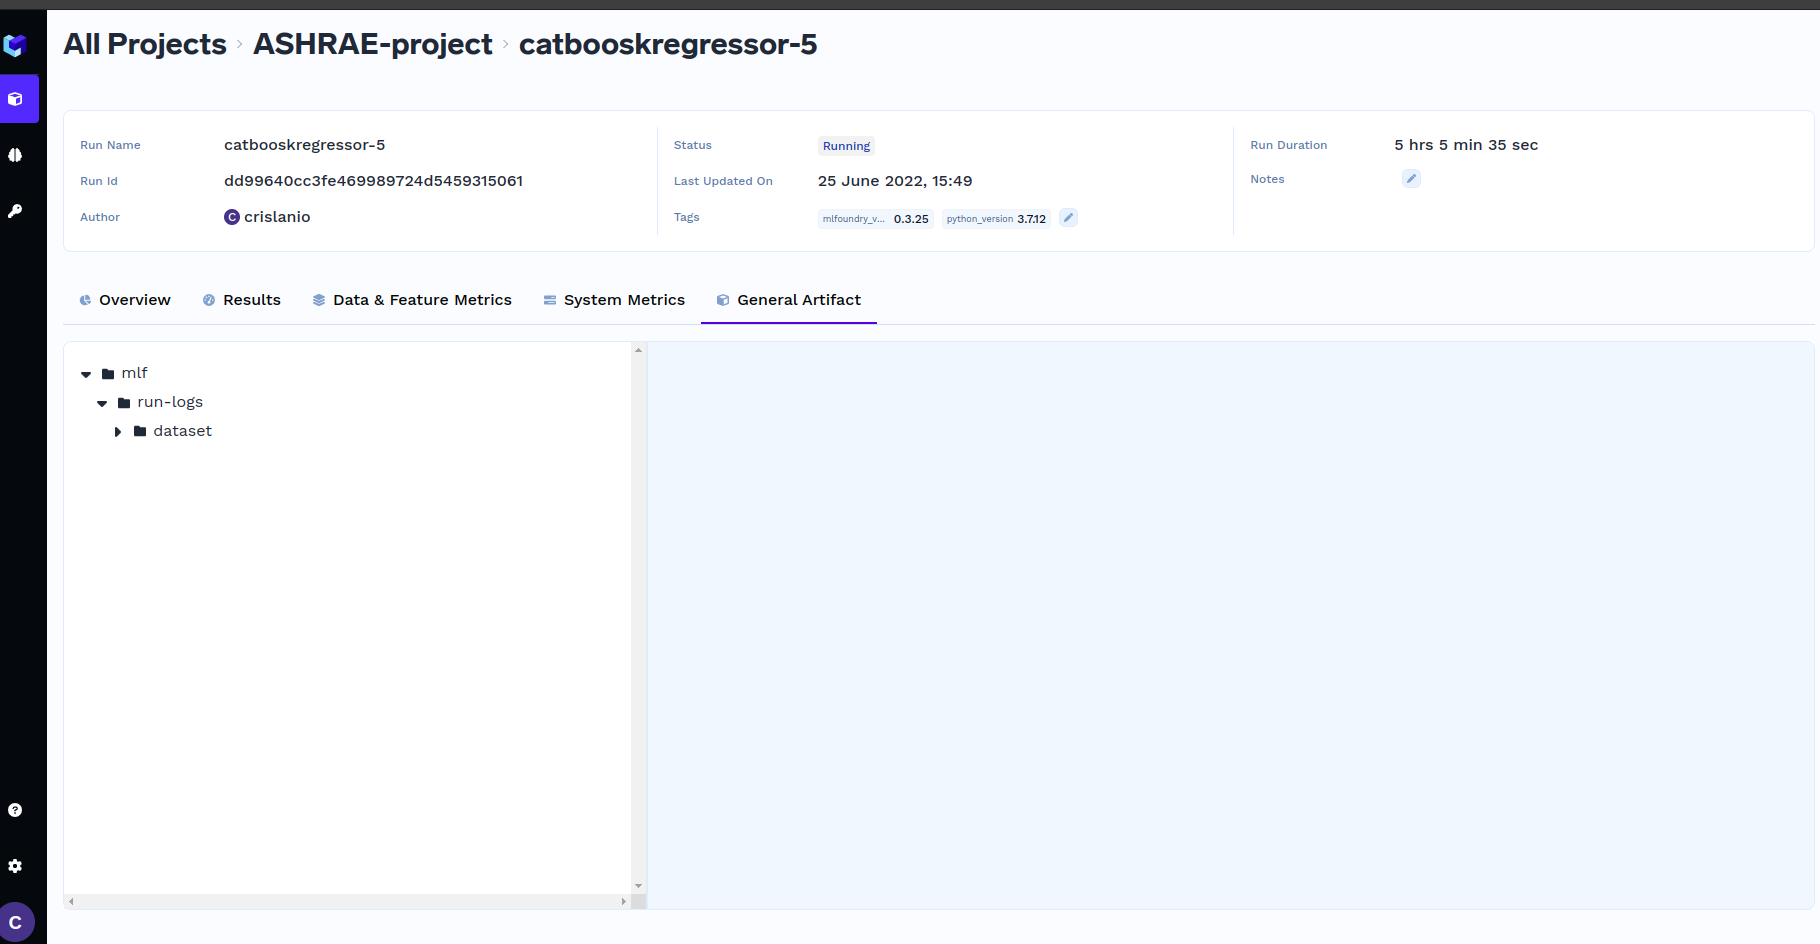

In [ ]:
import gc
del train_df #, train_X, val_X, lgb_train, lgb_eval, train_y, val_y, target
gc.collect()

In [ ]:
test_df = test_df[feat_cols]

In [ ]:
i=0
res=[]
step_size = 50000
for j in tqdm(range(int(np.ceil(test_df.shape[0]/50000)))):
    res.append(np.expm1(sum([model.predict(test_df.iloc[i:i+step_size]) for model in models])/folds))
    i+=step_size

In [ ]:
res = np.concatenate(res)

# <a id='11'>11. Submission</a>
<a href='#1'>Top</a>

In [ ]:
sample_submission['meter_reading'] = res
sample_submission.loc[sample_submission['meter_reading']<0, 'meter_reading'] = 0
sample_submission.to_csv('submission.csv', index=False)


sample_submission.head()

In [ ]:
sample_submission.head()

# <a id='13'>13. ASHRAE Energy prediction - summary</a>
<a href='#1'>Top</a>


<html>
<body>

<p><font size="4" color="Blue"> ASHRAE Standard 90.1 2010, Part III -- HVAC Provisions</font></p>

</body>
</html>


In [ ]:
HTML('<iframe width="829" height="622" src="https://www.youtube.com/embed/ABAR8TIwce4" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

> ## General findings


Published Articles on Energy Consumtion Prediction

- https://www.kaggle.com/c/ashrae-energy-prediction/discussion/113080#latest-665324

Geo location:

- https://www.kaggle.com/c/ashrae-energy-prediction/discussion/115040#latest-667889
- https://www.kaggle.com/c/ashrae-energy-prediction/discussion/115698#latest-667385
- https://www.kaggle.com/c/ashrae-energy-prediction/discussion/115698#latest-667385

Outliers:

- https://www.kaggle.com/c/ashrae-energy-prediction/discussion/113254

Holidays:

- https://www.kaggle.com/c/ashrae-energy-prediction/discussion/113286

Metric:

- https://www.kaggle.com/c/ashrae-energy-prediction/discussion/113064#latest-663076

Memory Storage:

- https://www.kaggle.com/c/ashrae-energy-prediction/discussion/112917#latest-663094

- https://www.kaggle.com/c/ashrae-energy-prediction/discussion/114754#latest-660345




<html>
<body>

<p><font size="3" color="Gray">⚡ Please, you can use parts of this notebook in your own scripts or kernels, no problem, but please give credit (for example link back to this, see this...)</font></p>

</body>
</html>




<html>
<body>

<p><font size="5" color="Blue">Remember the upvote button is next to the fork button, and it's free too! ;)</font></p>
<p><font size="4" color="Purple">Don't hesitate to give your suggestions in the comment section</font></p>

</body>
</html>


# Final